In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from generation.train.autoencoder import run_train, generate_new_signal
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

In [2]:
# Data params
SAMPLE_SIZE = 50
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

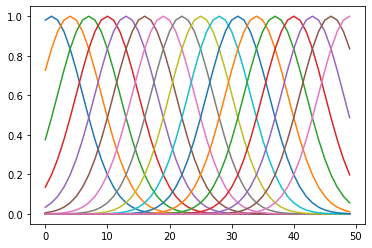

In [4]:
POINTS_NUM = 101
STD = 5

sample = data[0] #np.reshape(data[0], (len(data[0]), 1))
max_loc = np.argmax(signal.gaussian(POINTS_NUM, std=STD))
gaussians = []
for i in range(0, len(sample), 3):
    start_pos = max_loc - i - 1
    end_pos = start_pos + len(sample)
    values = signal.gaussian(POINTS_NUM, std=STD)[start_pos:end_pos]
    plt.plot(values)
    gaussians.append(values)
plt.show()

In [5]:
X = np.array(gaussians).T
y = sample.copy()
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50, 17)
y shape: (50,)


In [6]:
lr = Ridge(alpha=0.1)
lr.fit(X, y)

result = [lr.intercept_] * len(sample)
for i in range(len(gaussians)):
    result += lr.coef_[i] * gaussians[i]

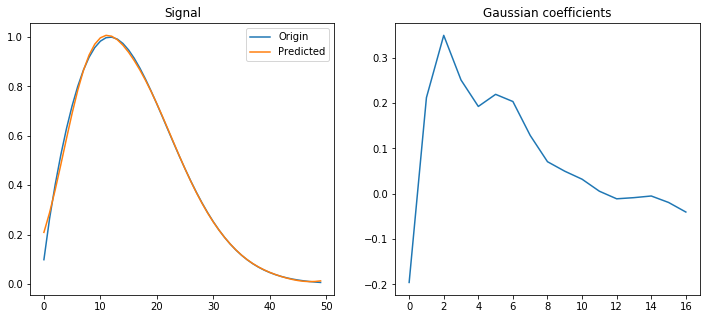

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Signal")
ax[0].plot(y)
ax[0].plot(result)
ax[0].legend(['Origin', 'Predicted'])
ax[1].set_title("Gaussian coefficients")
ax[1].plot(lr.coef_)
plt.show()

In [18]:
id_to_coef = {i: [] for i in range(len(data))}
id_to_intercept = {i: None for i in range(len(data))}

def transform_data(data, lr_alpha=0.1, std=5, coef=3):
    lr = Ridge(alpha=0.1)
    new_data = []
    for i, sample in enumerate(data):
        points_num = 2*len(sample) + 1
        max_loc = np.argmax(signal.gaussian(points_num, std=std))
        gaussians = []
        for j in range(0, len(sample), coef):
            start_pos = max_loc - j - 1
            end_pos = start_pos + len(sample)
            values = signal.gaussian(points_num, std=std)[start_pos:end_pos]
            gaussians.append(values)
            
        cur_X = np.array(gaussians).T
        cur_y = sample.copy()
        lr.fit(cur_X, cur_y)
        id_to_coef[i] = lr.coef_
        id_to_intercept[i] = lr.intercept_
        new_data.append(lr.coef_)
    return new_data

In [30]:
def back_transform_data(data):
    origin_data = []
    for i, sample in enumerate(data):
        result = [id_to_intercept[i]] * SAMPLE_SIZE
        for j in range(len(gaussians)):
            result += id_to_coef[i][j] * gaussians[j]
        origin_data.append(result)
    return origin_data

In [31]:
new_data = transform_data(data)